<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -20px">
        <strong>Curso:</strong> CC3104 - Aprendizaje por Refuerzo 
        &nbsp;&nbsp;&nbsp;
        <strong>Sección:</strong> 10
      </p>
      <p style="font-size: 16px; margin: 0;">
        <strong>Proyecto final:</strong> Agente de trading que aprenda a tomar decisiones de compra, venta o mantenimiento de un activo financiero dentro de un mercado simulado
      </p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
      </ul>
    </td>
  </tr>
</table>


Importación de librerías y configuración

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch  # type: ignore
import torch.nn as nn  # type: ignore
import torch.optim as optim  # type: ignore
from collections import deque, namedtuple
from typing import Deque, Tuple

# Reproducibilidad
SEED = 2000
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Dispositivo (CPU / GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Ajustes de gráficos
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

Using device: cpu


Hiperparámetros globales

In [2]:
# Entorno
N_STEPS = 4000          # longitud de pasos en entrenamiento
TEST_STEPS = 1200       # longitud en test
WINDOW = 30             # tamaño de la ventana de observación
TRANS_COST = 0.001      # costo de transacción por cambiar de posición
INIT_CASH = 1_000.0     # efectivo inicial
UNIT_POSITION = 1       # tamaño unitario de posición
ALLOW_SHORT = True      # permitir posición -1 (venta en corto)
VOL_SCALE = 0.20        # volatilidad anualizada para el GBM
DRIFT = 0.05            # drift anualizado para el GBM

# DQN / Double DQN
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 128
REPLAY_SIZE = 50_000
MIN_REPLAY = 2_000      # pasos mínimos antes de entrenar
TARGET_SYNC = 1000      # frecuencia de sync de la target network
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY_STEPS = 30_000
TRAIN_STEPS = 100_000   # total de pasos de entrenamiento
DOUBLE_DQN = True      # usar Double DQN

# Evaluación
RISK_FREE = 0.0         # asumimos tasa libre de riesgo 0 para Sharpe simple

## 1. Generación de precios y funciones auxiliares

En esta sección se define un modelo de mercado simulado usando **Geometric Brownian Motion (GBM)**, 
además de funciones para calcular retornos, Sharpe ratio, Max Drawdown y graficar las curvas de equity.


In [3]:
def geometric_brownian_motion(
        n_steps: int,
        s0: float = 100.0,
        mu: float = DRIFT,
        sigma: float = VOL_SCALE,
        dt: float = 1/252) -> np.ndarray:
    """Genera una trayectoria GBM discreta:
    S_{t+1} = S_t * exp((mu - 0.5 sigma^2) dt + sigma * sqrt(dt) * Z_t)
    Retorna un arreglo de precios (longitud n_steps).
    """
    prices = np.zeros(n_steps, dtype=np.float64)
    prices[0] = s0
    for t in range(1, n_steps):
        z = np.random.randn()
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * sigma**2) * dt
                                         + sigma * math.sqrt(dt) * z)
    return prices


def to_log_returns(prices: np.ndarray) -> np.ndarray:
    """Retornos logarítmicos r_t = log(S_t / S_{t-1})."""
    r = np.zeros_like(prices)
    r[1:] = np.diff(np.log(prices))
    return r


def sharpe_ratio(returns: np.ndarray, risk_free: float = RISK_FREE, eps: float = 1e-9) -> float:
    """Sharpe diario sobre retornos diarios: (media - rf) / std."""
    if returns.std() < eps:
        return 0.0
    return float((returns.mean() - risk_free) / (returns.std() + eps)) * math.sqrt(252)


def max_drawdown(equity: np.ndarray) -> float:
    """Máxima caída (drawdown) en porcentaje positivo, e.g. 0.25 = 25%."""
    peaks = np.maximum.accumulate(equity)
    drawdowns = 1.0 - (equity / np.maximum(peaks, 1e-9))
    return float(drawdowns.max())


def plot_equity(equity_dict: dict, title="Equity curves"):
    """Gráfico para curvas de equidad (valor de portafolio en el tiempo)."""
    for label, eq in equity_dict.items():
        plt.plot(eq, label=label)
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Equity (value)")
    plt.legend()
    plt.show()

## 2. Entorno de trading

Definimos un entorno uniactivo con acciones discretas `{sell, hold, buy}` que se mapean a posiciones `{−1, 0, +1}`. La recompensa es el cambio en el valor del portafolio neto de costos.


In [4]:
class TradingEnv:
    """Entorno de trading uniactivo con acciones discretas {sell, hold, buy} -> posiciones {-1, 0, +1}.
    Recompensa = Δ(valor portafolio) neto de costos al cambiar de posición.
    Observación = [ventana de retornos recientes, posición_actual].
    """
    def __init__(self, prices: np.ndarray, window: int = WINDOW, trans_cost: float = TRANS_COST, init_cash: float = INIT_CASH, allow_short: bool = True):
        self.prices = prices.astype(np.float64)
        self.returns = to_log_returns(self.prices)
        self.window = window
        self.trans_cost = trans_cost
        self.init_cash = init_cash
        self.allow_short = allow_short
        self.reset()

    def reset(self):
        self.t = self.window  # primer índice válido para ventana
        self.cash = float(self.init_cash)
        self.position = 0     # -1, 0, +1
        self.equity = [self.cash]
        self.last_price = float(self.prices[self.t-1])
        return self._get_obs()

    def _get_obs(self):
        # obs = [retornos_window, posición_norm]
        window_rets = self.returns[self.t - self.window : self.t]
        pos_norm = np.array([self.position], dtype=np.float32)  # ya está en [-1,0,1]
        obs = np.concatenate([window_rets.astype(np.float32), pos_norm], axis=0)
        return obs

    def step(self, action: int):
        """Avanza un paso en el entorno dado una acción en {0,1,2} -> {sell, hold, buy}."""
        assert action in (0, 1, 2)

        if action == 0:  # sell -> posición -1
            new_pos = -1 if self.allow_short else 0
        elif action == 1:  # hold -> mantener
            new_pos = self.position
        else:  # buy -> +1
            new_pos = 1

        price_t = float(self.prices[self.t])
        price_tm1 = float(self.prices[self.t - 1])
        ret_t = math.log(price_t / price_tm1 + 1e-12)  # retorno log

        # PnL por tener la posición previa en [t-1, t]
        pnl = self.position * ret_t * self.cash  # aproximación: escala sobre cash

        # Costo por cambiar de posición (si hay cambio)
        delta_pos = abs(new_pos - self.position)
        cost = delta_pos * self.trans_cost * price_t * UNIT_POSITION

        # Actualizar estado financiero
        self.cash += pnl - cost
        self.position = new_pos
        self.equity.append(self.cash)

        # Recompensa = delta equity paso a paso (pnl - cost)
        reward = pnl - cost

        self.t += 1
        done = self.t >= len(self.prices)
        obs = self._get_obs() if not done else None
        info = {"pnl": pnl, "cost": cost, "price": price_t}
        return obs, float(reward), bool(done), info

## 3. Datos de entrenamiento y prueba del entorno

Se generan dos trayectorias de precios: una para entrenamiento y otra para evaluación (test). 
Se incluye un *sanity check* usando una política aleatoria.


Random steps: 200, reward mean=0.521521, equity=1104.30


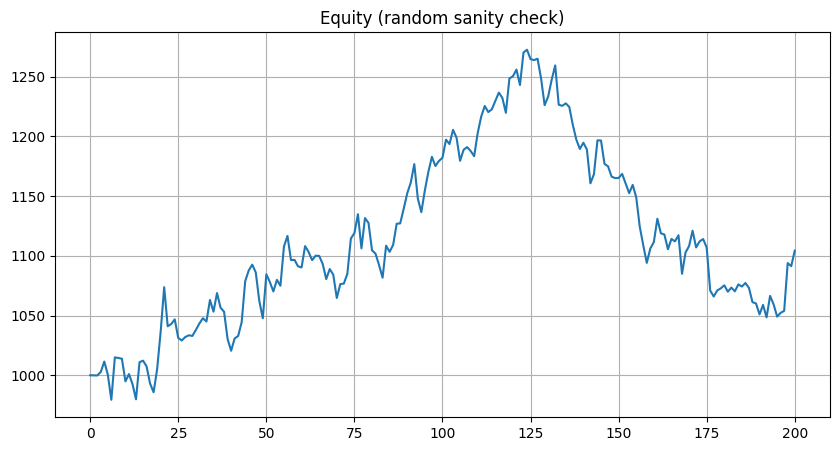

In [5]:
# Datos de entrenamiento
train_prices = geometric_brownian_motion(N_STEPS, s0=100.0, mu=DRIFT, sigma=VOL_SCALE)
env_train = TradingEnv(train_prices, window=WINDOW, trans_cost=TRANS_COST, init_cash=INIT_CASH, allow_short=ALLOW_SHORT)

# Datos de test (trayectoria distinta)
test_prices = geometric_brownian_motion(TEST_STEPS, s0=train_prices[-1], mu=DRIFT, sigma=VOL_SCALE)
env_test = TradingEnv(test_prices, window=WINDOW, trans_cost=TRANS_COST, init_cash=INIT_CASH, allow_short=ALLOW_SHORT)

# Sanity check con política aleatoria
obs = env_train.reset()
rewards = []
for _ in range(200):
    a = np.random.randint(0, 3)
    obs, r, done, info = env_train.step(a)
    rewards.append(r)
    if done:
        break

print(f"Random steps: {len(rewards)}, reward mean={np.mean(rewards):.6f}, equity={env_train.equity[-1]:.2f}")
plt.plot(env_train.equity)
plt.title("Equity (random sanity check)")
plt.show()

## 4. Replay buffer

Se implementa un buffer de repetición para almacenar transiciones y muestrear minibatches durante el entrenamiento del agente DQN.


In [6]:
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, capacity: int = REPLAY_SIZE):
        self.buffer: Deque[Transition] = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Transition:
        batch = random.sample(self.buffer, batch_size)
        states = np.stack([b.state for b in batch], axis=0)
        actions = np.array([b.action for b in batch], dtype=np.int64)
        rewards = np.array([b.reward for b in batch], dtype=np.float32)
        next_states = np.stack([b.next_state for b in batch], axis=0)
        dones = np.array([b.done for b in batch], dtype=np.float32)
        return Transition(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

## 5. Red Q y agente Deep Q-Network (con opción Double DQN y Dueling DQN)

Se define la red neuronal que aproxima Q(s, a) y el agente DQN, con una bandera para activar o desactivar Double DQN.


In [7]:
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, n_actions: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, input_dim: int, n_actions: int = 3):
        super().__init__()
        # Bloque común
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU()
        )
        # Rama de valor V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
        # Rama de ventaja A(s,a)
        self.adv_stream = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)               # [B, 1]
        adv = self.adv_stream(x)                   # [B, A]
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,.)))
        adv_mean = adv.mean(dim=1, keepdim=True)   # [B, 1]
        qvals = value + (adv - adv_mean)           # [B, A]
        return qvals


class DQNAgent:
    def __init__(self, obs_dim: int, n_actions: int = 3, gamma: float = GAMMA, lr: float = LR, double_dqn: bool = DOUBLE_DQN, dueling: bool = False):
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.double_dqn = double_dqn
        self.dueling = dueling

        # Elegir arquitectura: clásica o dueling
        NetClass = DuelingQNetwork if dueling else QNetwork

        self.q = NetClass(obs_dim, n_actions).to(DEVICE)
        self.q_target = NetClass(obs_dim, n_actions).to(DEVICE)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()

        self.optim = optim.Adam(self.q.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.eps = EPS_START

    def act(self, obs: np.ndarray) -> int:
        if np.random.rand() < self.eps:
            return np.random.randint(0, self.n_actions)
        with torch.no_grad():
            x = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            qvals = self.q(x)
            return int(torch.argmax(qvals, dim=1).item())

    def update_eps(self, step: int):
        # Decaimiento lineal hasta EPS_END
        frac = min(1.0, step / EPS_DECAY_STEPS)
        self.eps = EPS_START + frac * (EPS_END - EPS_START)

    @torch.no_grad()
    def _q_next_targets(self, next_states: torch.Tensor) -> torch.Tensor:
        # Double DQN: seleccionar acción con Q online y evaluar con Q target
        if self.double_dqn:
            next_q_online = self.q(next_states)                 # [B, A]
            next_actions = torch.argmax(next_q_online, dim=1)   # [B]
            next_q_target = self.q_target(next_states)          # [B, A]
            next_best = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_q_target = self.q_target(next_states)          # [B, A]
            next_best, _ = torch.max(next_q_target, dim=1)
        return next_best

    def train_step(self, batch: Transition):
        states = torch.tensor(batch.state, dtype=torch.float32, device=DEVICE)
        actions = torch.tensor(batch.action, dtype=torch.int64, device=DEVICE).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=DEVICE)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=DEVICE)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=DEVICE)

        qvals = self.q(states).gather(1, actions).squeeze(1)   # Q(s,a)

        with torch.no_grad():
            next_best = self._q_next_targets(next_states)
            targets = rewards + (1.0 - dones) * self.gamma * next_best

        loss = self.loss_fn(qvals, targets)
        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), 1.0)
        self.optim.step()

        return float(loss.item())

    def sync_target(self):
        self.q_target.load_state_dict(self.q.state_dict())

## 6. Función de entrenamiento del agente

Se define una función genérica `train_dqn_agent` que entrena un agente DQN o Double DQN 
según el parámetro `double_dqn` o un agente Dueling DQN bajo el parametro `dueling`, y devuelve las curvas de recompensa y equity.

In [8]:
def train_dqn_agent(
    prices: np.ndarray,
    label: str = "DQN",
    train_steps: int = TRAIN_STEPS,
    double_dqn: bool = True,
    dueling: bool = False,
):
    env = TradingEnv(
        prices=prices,
        window=WINDOW,
        trans_cost=TRANS_COST,
        init_cash=INIT_CASH,
        allow_short=ALLOW_SHORT,
    )

    buffer = ReplayBuffer(REPLAY_SIZE)
    agent = DQNAgent(
        obs_dim=WINDOW + 1,
        n_actions=3,
        gamma=GAMMA,
        lr=LR,
        double_dqn=double_dqn,
        dueling=dueling,
    )

    obs = env.reset()
    rewards, equity_track, losses = [], [], []

    for step in range(1, train_steps + 1):
        agent.update_eps(step)
        action = agent.act(obs) # type: ignore
        next_obs, reward, done, _ = env.step(action)

        if not done:
            buffer.push(obs, action, reward, next_obs, 0.0)
            obs = next_obs
        else:
            buffer.push(obs, action, reward, np.zeros_like(obs, dtype=np.float32), 1.0)
            obs = env.reset()

        rewards.append(reward)
        equity_track.append(env.equity[-1])

        if len(buffer) >= MIN_REPLAY:
            batch = buffer.sample(BATCH_SIZE)
            loss = agent.train_step(batch)
            losses.append(loss)

        if step % TARGET_SYNC == 0:
            agent.sync_target()

        if step % 5000 == 0:
            print(f"[{label}] Step {step:6d} | eps={agent.eps:.3f} "f"| meanReward(last5k)={np.mean(rewards[-5000:]):.6f} "f"| equity={equity_track[-1]:.2f}")

    return {
        "agent": agent,
        "equity": np.array(equity_track),
        "rewards": np.array(rewards),
        "losses": np.array(losses),
    }


## 7. Entrenamiento base del agente DQN

[Base DQN] Step   5000 | eps=0.842 | meanReward(last5k)=-0.256515 | equity=646.94
[Base DQN] Step  10000 | eps=0.683 | meanReward(last5k)=-0.056156 | equity=1428.66
[Base DQN] Step  15000 | eps=0.525 | meanReward(last5k)=0.324765 | equity=2606.13
[Base DQN] Step  20000 | eps=0.367 | meanReward(last5k)=0.161798 | equity=1177.16
[Base DQN] Step  25000 | eps=0.208 | meanReward(last5k)=0.780443 | equity=3808.25
[Base DQN] Step  30000 | eps=0.050 | meanReward(last5k)=3.209257 | equity=5769.35
[Base DQN] Step  35000 | eps=0.050 | meanReward(last5k)=4.900065 | equity=7527.74
[Base DQN] Step  40000 | eps=0.050 | meanReward(last5k)=2.904053 | equity=1279.79
[Base DQN] Step  45000 | eps=0.050 | meanReward(last5k)=1.271308 | equity=2285.27
[Base DQN] Step  50000 | eps=0.050 | meanReward(last5k)=6.546128 | equity=6360.05
[Base DQN] Step  55000 | eps=0.050 | meanReward(last5k)=9.677902 | equity=28256.37
[Base DQN] Step  60000 | eps=0.050 | meanReward(last5k)=8.577540 | equity=1905.71
[Base DQN] Ste

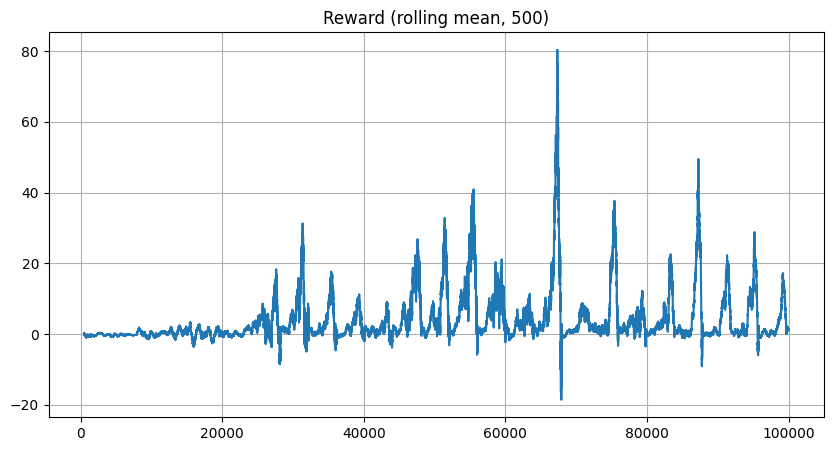

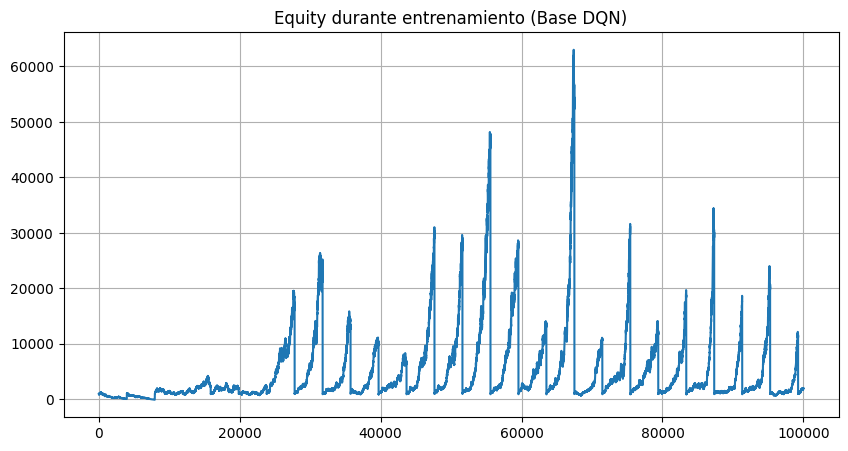

In [9]:
# Entrenamiento base con Double DQN
results_base = train_dqn_agent(train_prices, label="Base DQN", double_dqn=False, dueling=False)

agent = results_base["agent"]  # agente base para evaluación
train_rewards = results_base["rewards"]
equity_track = results_base["equity"]

# Curvas de entrenamiento (reward suavizado y equity)
pd.Series(train_rewards).rolling(500).mean().plot()
plt.title("Reward (rolling mean, 500)")
plt.show()
plt.plot(equity_track)
plt.title("Equity durante entrenamiento (Base DQN)")
plt.show()

## 8. Evaluación en el conjunto de prueba y comparación con estrategias base


TEST Base DQN | Total Return=52.74% | Sharpe=0.450 | MaxDD=21.86%


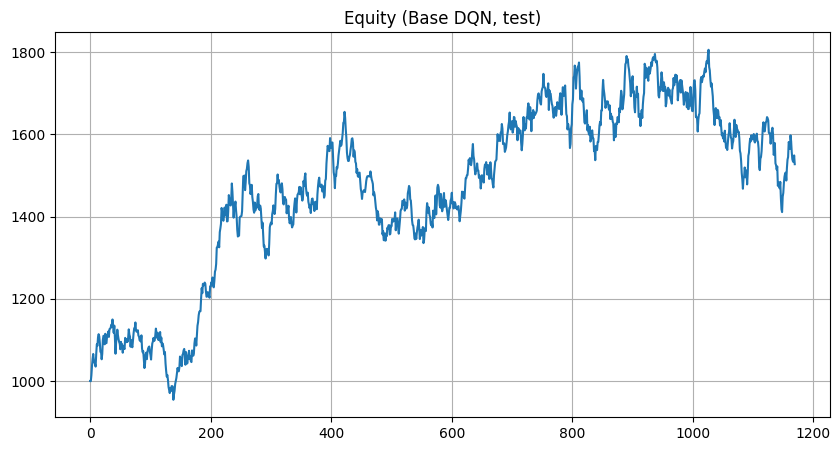

,Estrategia,Retorno (%),Sharpe,Max Drawdown (%)
0,Random,-70.972,-1.315,75.911
1,Buy & Hold,-1.973,-0.021,42.373
2,DQN,52.741,0.450,21.859


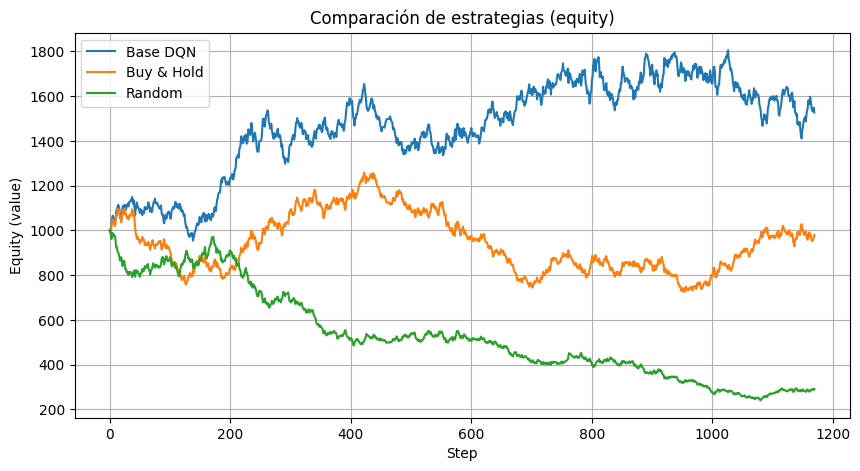

In [10]:
def run_episode(env: TradingEnv, policy_fn, render: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    obs = env.reset()
    rewards, equity = [], []
    while True:
        a = policy_fn(obs)
        obs, r, done, info = env.step(a)
        rewards.append(r)
        equity.append(env.equity[-1])
        if done:
            break
    return np.array(rewards, dtype=np.float32), np.array(equity, dtype=np.float64)


# Política greedy sin exploración para el agente base
def greedy_policy(obs):
    with torch.no_grad():
        x = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        qvals = agent.q(x)
        return int(torch.argmax(qvals, dim=1).item())


# Evaluación del agente base en test
test_rewards, test_equity = run_episode(env_test, greedy_policy)
test_returns = np.diff(np.log(test_equity + 1e-9), prepend=np.log(test_equity[0] + 1e-9))

sr = sharpe_ratio(test_returns)
mdd = max_drawdown(test_equity)
ret_total = (test_equity[-1] / test_equity[0]) - 1.0

print(f"TEST Base DQN | Total Return={ret_total:.2%} | Sharpe={sr:.3f} | MaxDD={mdd:.2%}")
plt.plot(test_equity)
plt.title("Equity (Base DQN, test)")
plt.show()


# Estrategias base
def buy_and_hold_policy(obs):
    # acción "buy" persistente: 2
    return 2

def random_policy(obs):
    return np.random.randint(0, 3)


bh_rewards, bh_equity = run_episode(
    TradingEnv(test_prices, WINDOW, TRANS_COST, INIT_CASH, ALLOW_SHORT),
    buy_and_hold_policy,
)
rd_rewards, rd_equity = run_episode(
    TradingEnv(test_prices, WINDOW, TRANS_COST, INIT_CASH, ALLOW_SHORT),
    random_policy,
)

base_metrics = {
    "return": (test_equity[-1]/test_equity[0])-1,
    "sharpe": sharpe_ratio(np.diff(np.log(test_equity+1e-9), prepend=np.log(test_equity[0]+1e-9))),
    "mdd": max_drawdown(test_equity),
}
bh_metrics = {
    "return": (bh_equity[-1]/bh_equity[0])-1,
    "sharpe": sharpe_ratio(np.diff(np.log(bh_equity+1e-9), prepend=np.log(bh_equity[0]+1e-9))),
    "mdd": max_drawdown(bh_equity),
}
rd_metrics = {
    "return": (rd_equity[-1]/rd_equity[0])-1,
    "sharpe": sharpe_ratio(np.diff(np.log(rd_equity+1e-9), prepend=np.log(rd_equity[0]+1e-9))),
    "mdd": max_drawdown(rd_equity),
}

df_comparison = pd.DataFrame([
    ["Random",      rd_metrics["return"]*100, rd_metrics["sharpe"], rd_metrics["mdd"]*100],
    ["Buy & Hold",  bh_metrics["return"]*100,   bh_metrics["sharpe"],   bh_metrics["mdd"]*100],
    ["DQN",         base_metrics["return"]*100,   base_metrics["sharpe"],   base_metrics["mdd"]*100],
], columns=["Estrategia", "Retorno (%)", "Sharpe", "Max Drawdown (%)"])

display(df_comparison.round(3))

plot_equity({
    "Base DQN": test_equity,
    "Buy & Hold": bh_equity,
    "Random": rd_equity,
}, title="Comparación de estrategias (equity)")

## 9. Análisis cualitativo de la política aprendida

In [11]:
def inspect_policy(env: TradingEnv, n: int = 200):
    obs = env.reset()
    acts = []
    for _ in range(n):
        a = greedy_policy(obs)
        acts.append(a)
        obs, r, done, info = env.step(a)
        if done:
            break
    actions_map = {0: "SELL(-1)", 1: "HOLD(=)", 2: "BUY(+1)"}
    counts = pd.Series(acts).map(actions_map).value_counts()
    display(counts)


inspect_policy(TradingEnv(test_prices, WINDOW, TRANS_COST, INIT_CASH, ALLOW_SHORT), n=500)

BUY(+1)     230
HOLD(=)     153
SELL(-1)    117
Name: count, dtype: int64

## 10. Comparación DQN vs Double DQN vs Dueling DQN

In [ ]:
results_dqn = train_dqn_agent(train_prices, label="DQN", double_dqn=False)
results_ddqn = train_dqn_agent(train_prices, label="Double DQN", double_dqn=True)
results_dueling = train_dqn_agent(train_prices, label="Dueling DQN", double_dqn=False, dueling=True)


def evaluate_agent(agent: DQNAgent, prices: np.ndarray):
    env = TradingEnv(prices, WINDOW, TRANS_COST, INIT_CASH, ALLOW_SHORT)

    def _greedy(obs):
        with torch.no_grad():
            x = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            qvals = agent.q(x)
            return int(torch.argmax(qvals, dim=1).item())

    rewards, equity = run_episode(env, _greedy)
    returns = np.diff(np.log(equity + 1e-9), prepend=np.log(equity[0] + 1e-9))

    return {
        "equity": equity,
        "total_return": (equity[-1] / equity[0]) - 1.0,
        "sharpe": sharpe_ratio(returns),
        "mdd": max_drawdown(equity),
    }


metrics_dqn = evaluate_agent(results_dqn["agent"], test_prices)
metrics_ddqn = evaluate_agent(results_ddqn["agent"], test_prices)
metrics_dueling  = evaluate_agent(results_dueling["agent"], test_prices)

# Recalcular métricas de estrategias base para esta tabla comparativa
bh_rewards2, bh_equity2 = run_episode(
    TradingEnv(test_prices, WINDOW, TRANS_COST, INIT_CASH, ALLOW_SHORT),
    buy_and_hold_policy,
)
rd_rewards2, rd_equity2 = run_episode(
    TradingEnv(test_prices, WINDOW, TRANS_COST, INIT_CASH, ALLOW_SHORT),
    random_policy,
)

metrics_bh2 = {
    "equity": bh_equity2,
    "total_return": (bh_equity2[-1]/bh_equity2[0]) - 1,
    "sharpe": sharpe_ratio(np.diff(np.log(bh_equity2+1e-9), prepend=np.log(bh_equity2[0]+1e-9))),
    "mdd": max_drawdown(bh_equity2),
}
metrics_rand2 = {
    "equity": rd_equity2,
    "total_return": (rd_equity2[-1]/rd_equity2[0]) - 1,
    "sharpe": sharpe_ratio(np.diff(np.log(rd_equity2+1e-9), prepend=np.log(rd_equity2[0]+1e-9))),
    "mdd": max_drawdown(rd_equity2),
}

[DQN] Step   5000 | eps=0.842 | meanReward(last5k)=-0.106798 | equity=1751.90
[DQN] Step  10000 | eps=0.683 | meanReward(last5k)=-0.099978 | equity=815.38
[DQN] Step  15000 | eps=0.525 | meanReward(last5k)=-0.121336 | equity=729.29
[DQN] Step  20000 | eps=0.367 | meanReward(last5k)=0.154174 | equity=1444.58
[DQN] Step  25000 | eps=0.208 | meanReward(last5k)=0.314061 | equity=1784.01
[DQN] Step  30000 | eps=0.050 | meanReward(last5k)=0.999390 | equity=2334.06
[DQN] Step  35000 | eps=0.050 | meanReward(last5k)=3.968471 | equity=18013.03
[DQN] Step  40000 | eps=0.050 | meanReward(last5k)=2.119550 | equity=1945.56
[DQN] Step  45000 | eps=0.050 | meanReward(last5k)=10.114296 | equity=3114.03
[DQN] Step  50000 | eps=0.050 | meanReward(last5k)=21.892148 | equity=3172.78
[DQN] Step  55000 | eps=0.050 | meanReward(last5k)=6.590759 | equity=18545.76
[DQN] Step  60000 | eps=0.050 | meanReward(last5k)=9.899161 | equity=2331.02
[DQN] Step  65000 | eps=0.050 | meanReward(last5k)=11.141328 | equity=3

,Estrategia,Retorno (%),Sharpe,Max Drawdown (%)
0,Random,-62.826,-1.049,71.616
1,Buy & Hold,-1.973,-0.021,42.373
2,DQN,-30.086,-0.380,43.978
3,Double DQN,-36.695,-0.486,50.928
4,Dueling DQN,-25.901,-0.318,42.968


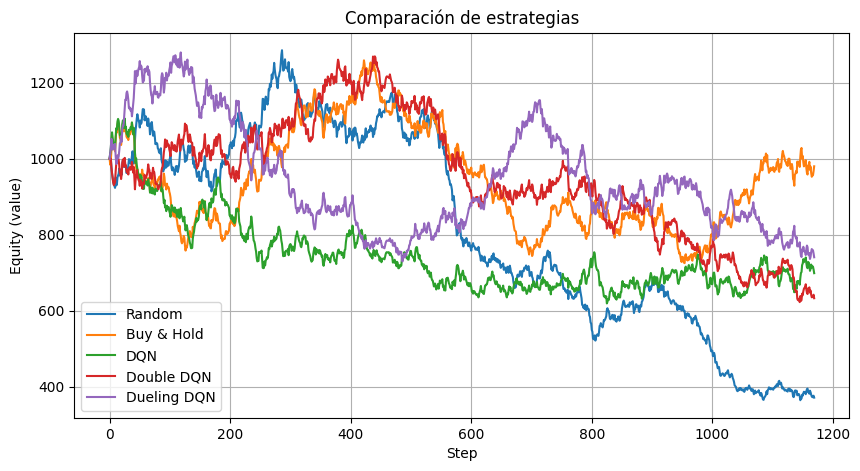

In [13]:
df_comparison = pd.DataFrame([
    ["Random",      metrics_rand2["total_return"]*100, metrics_rand2["sharpe"], metrics_rand2["mdd"]*100],
    ["Buy & Hold",  metrics_bh2["total_return"]*100,   metrics_bh2["sharpe"],   metrics_bh2["mdd"]*100],
    ["DQN",         metrics_dqn["total_return"]*100,   metrics_dqn["sharpe"],   metrics_dqn["mdd"]*100],
    ["Double DQN",  metrics_ddqn["total_return"]*100,  metrics_ddqn["sharpe"],  metrics_ddqn["mdd"]*100],
    ["Dueling DQN", metrics_dueling["total_return"]*100, metrics_dueling["sharpe"], metrics_dueling["mdd"]*100],
], columns=["Estrategia", "Retorno (%)", "Sharpe", "Max Drawdown (%)"])

display(df_comparison.round(3))

plot_equity({
    "Random": metrics_rand2["equity"],
    "Buy & Hold": metrics_bh2["equity"],
    "DQN": metrics_dqn["equity"],
    "Double DQN": metrics_ddqn["equity"],
    "Dueling DQN": metrics_dueling["equity"],
}, title="Comparación de estrategias")